In [1]:
import os
os.chdir('/content')
CODE_DIR = 'InvertibleCE'
!git clone https://github.com/zhangrh93/InvertibleCE $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!pip install -r requirements.txt > installation_output.txt

Cloning into 'InvertibleCE'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 241 (delta 72), reused 204 (delta 38), pack-reused 0
Receiving objects: 100% (241/241), 11.45 MiB | 33.70 MiB/s, done.
Resolving deltas: 100% (72/72), done.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


# MNIST model with GlobalAveragePooling


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  
import os
import torchvision
import numpy as np

import os
from pathlib import Path

from torchsummary import summary
import shutil

seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

## Model structure
Let's build a simple MNIST model for ICE explanations. It contains 6 convolutional layers with Relu activation functions. One Global Average Pooling layer (GAP) and one dense layer are used at last.

In [3]:
log_batch = 10
unit_num = 16

def _make_layer(in_shape, out_shape, unit_num):
    return nn.Sequential(
        nn.Conv2d(in_shape, unit_num, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(unit_num, out_shape, 3, 1, 1),
        nn.ReLU(inplace=True),
    )
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = _make_layer(1,unit_num,unit_num)
        self.layer2 = _make_layer(unit_num,unit_num*2,unit_num*2)
        self.layer3 = _make_layer(unit_num*2,unit_num*4,unit_num*4)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(unit_num*4, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer3(x)
        x = self.gap(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



use_cuda = torch.cuda.is_available()
model = Net()
if use_cuda:
    model = model.cuda()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Pytorch dataloader
Next, we need to download the MNIST dataset. Datasets are stored in '/dataset'.

In [4]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root = "./dataset",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./dataset",
                           transform = transform,
                           train = False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                 num_workers=0)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = True,
                                                num_workers=0)


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## MNIST model training 
We do not want a perfect MNIST classifier. Around 97% accuracy is enough for the explanations.

Trained models are stored in the './model' folder.

In [5]:
if not os.path.exists(Path('model')):
    os.mkdir(Path('model'))

RETRAIN = False
MODEL_PATH = Path('model/MNIST_model.pt') 

if not os.path.exists(MODEL_PATH) or RETRAIN:

    cost = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    n_epochs = 10
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, n_epochs))
        print("-"*10)
        for data in data_loader_train:
            X_train, y_train = data
            if use_cuda:
                X_train, y_train = X_train.cuda(), y_train.cuda()
            outputs = F.softmax(model(X_train))
            _,pred = torch.max(outputs.data, 1)
            optimizer.zero_grad()
            loss = cost(outputs, y_train)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += torch.sum(pred == y_train.data).item()
        testing_correct = 0
        for data in data_loader_test:
            X_test, y_test = data
            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            outputs = model(X_test)
            _, pred = torch.max(outputs.data, 1)
            testing_correct += torch.sum(pred == y_test.data).item()
        print("Loss is:{:.8f}, Train Accuracy is:{:.2f}%, Test Accuracy is:{:.2f}%".format(running_loss*batch_size/len(data_train),
                                                                                          100*running_correct/len(data_train),
                                                                                          100*testing_correct/len(data_test)))
        
    torch.save(model.state_dict(),MODEL_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    print ('model loaded!')

Epoch 0/10
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Loss is:1.85872170, Train Accuracy is:60.00%, Test Accuracy is:68.28%
Epoch 1/10
----------
Loss is:1.72646059, Train Accuracy is:73.37%, Test Accuracy is:86.91%
Epoch 2/10
----------
Loss is:1.53411922, Train Accuracy is:92.77%, Test Accuracy is:96.53%
Epoch 3/10
----------
Loss is:1.50091042, Train Accuracy is:96.07%, Test Accuracy is:97.60%
Epoch 4/10
----------
Loss is:1.49361019, Train Accuracy is:96.78%, Test Accuracy is:97.27%
Epoch 5/10
----------
Loss is:1.48880799, Train Accuracy is:97.27%, Test Accuracy is:97.83%
Epoch 6/10
----------
Loss is:1.48442748, Train Accuracy is:97.71%, Test Accuracy is:98.05%
Epoch 7/10
----------
Loss is:1.48277434, Train Accuracy is:97.85%, Test Accuracy is:98.14%
Epoch 8/10
----------
Loss is:1.48158608, Train Accuracy is:97.97%, Test Accuracy is:97.61%
Epoch 9/10
----------
Loss is:1.48015032, Train Accuracy is:98.10%, Test Accuracy is:98.06%


# ICE Explainer for MNIST model

Now, for the ICE Explanations.
1. Wrap the model. Set all related classes.
2. Create a loader list. Each loader only contains samples from one class.
3. Create the Explainer, train the reducer model and generate explanations.



## Parameters, data loader and model wrapper
Some parameters required:
* Target classes with correlated names (explanation domains): [3,8]
* Concept targer layer: 'layer3'
* n_components for NMF reducer: 8
* Explainer title: MNIST_layer3_8_[3_8]


In [6]:
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils
import shutil


target_classes = [3,8]
classes_names = [str(i) for i in target_classes]
layer_name = 'layer3'
n_components = 6
title = "MNIST_{}_{}_[".format(layer_name,n_components)+"_".join(classes_names) + ']'



print ("title:{}".format(title))
print ("target_classes:{}".format(target_classes))
print ("classes_names:{}".format(classes_names))
print ("n_components:{}".format(n_components))
print ("layer_name:{}".format(layer_name))


model = model.cuda()
model.eval()
wm = ICE.ModelWrapper.PytorchModelWrapper(model,batch_size=batch_size,predict_target=target_classes,input_size = [1,28,28],input_channel_first = True,model_channel_first = True)

X,y = data_train.data,data_train.targets
loaders = []
for target in target_classes:
    tdataset = torch.utils.data.TensorDataset(X[y==target].unsqueeze(1))
    loaders.append(torch.utils.data.DataLoader(tdataset,batch_size=batch_size))


title:MNIST_layer3_6_[3_8]
target_classes:[3, 8]
classes_names:['3', '8']
n_components:6
layer_name:layer3


## ICE Explainer training

Depends on the dataset size, the training may take several minutes. You can change the CALC_LIMIT value in Explainer.py to reduce the dataset size.

In [7]:

print ("-------------------------------------------------------------------------------------------")

try:
    shutil.rmtree('Explainers/'+title)
except:
    pass
# create an Explainer
Exp = ICE.Explainer.Explainer(title = title,
                layer_name = layer_name,
                class_names = classes_names,
                utils = ICE.utils.img_utils(img_size = (28,28),nchannels=1,img_format='channels_first'),
                n_components = n_components,
                reducer_type = "NMF"
               )

# train reducer based on target classes
Exp.train_model(wm,loaders)
# generate features 
Exp.generate_features(wm, loaders)
# generate global explanations
Exp.global_explanations()
# save the explainer, use load() to load it with the same title
Exp.save()


-------------------------------------------------------------------------------------------
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (11982, 7, 7, 64)
2/5 Reducer trained, spent 16.482356071472168 s.
3/5 Error estimated, fidelity: [0.08593038 0.08804225].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5]
loading training data
Done with class: 3, 1/2
Done with class: 8, 2/2
Generate explanations with fullset condition


Save and load exist explainers. You can load the explainer by the title.

In [8]:
# you can load exist explainers with title
Exp = ICE.Explainer.Explainer(title = title)
Exp.load()

## Global explanations

Global explanations are already generated before, you can compare the difference between those explanations of class 3 and 8.

Here feature_0 is a commonly appear features in nearly all instances (3 can be considered as a part of 8).

Number 8 has unique concepts like feature_2. For number 3, feature_3 may not appear in instances of number 8.

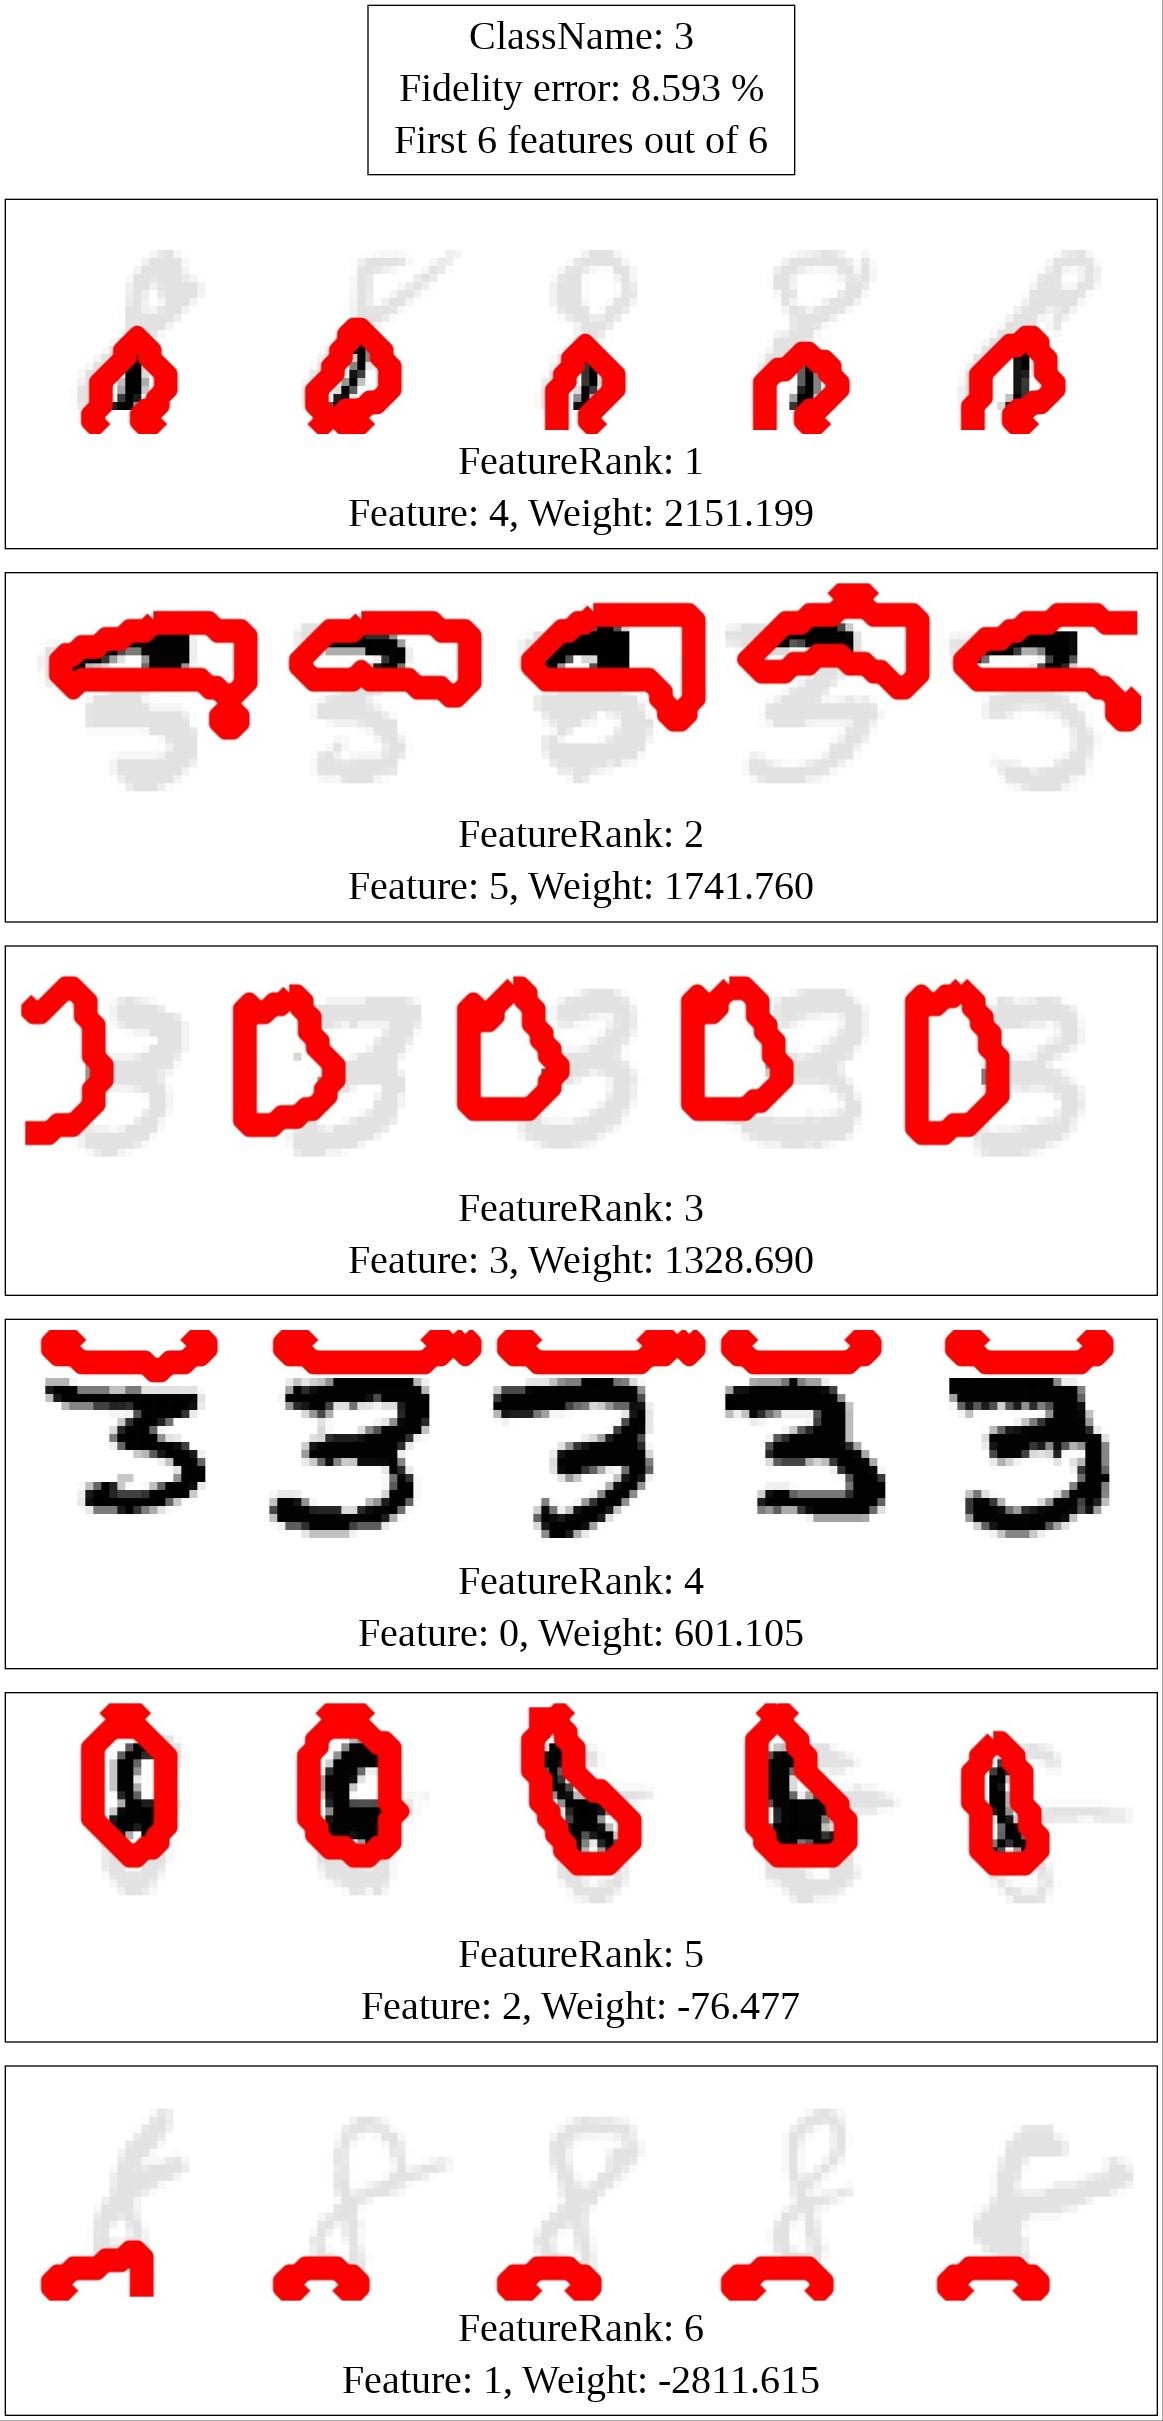

In [13]:
from IPython.display import HTML, display, Image
import os
from pathlib import Path

#@title { display-mode: "form", run: "auto" }

fpath = Path('Explainers').absolute() / title / 'GE'
imgfile = '3.jpg' #@param ['3.jpg', '8.jpg']

display(Image(str(fpath/imgfile)))


## Local Explanations

Local explanations for a '3'.

Let's get an instance from test set and locally explain it.

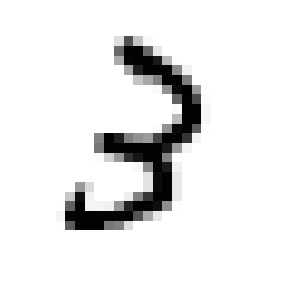

(1, 28, 28)


In [10]:
x = data_test.data[data_test.targets==3][5]
x = x.unsqueeze(0)
Exp.utils.show_img([Exp.utils.deprocessing(x.permute(0,2,1).numpy())])

x = x.numpy()
print (x.shape)

Local explanation requires an instance and the wrapped model.

In [11]:
Exp.local_explanations(x,wm,name='LE_3')

The last line in each explanation reports the real model's prediction and how much those predictions are displayed by this explanation. Here Total contribution is the score of restructed feature map from the reduced feature maps.

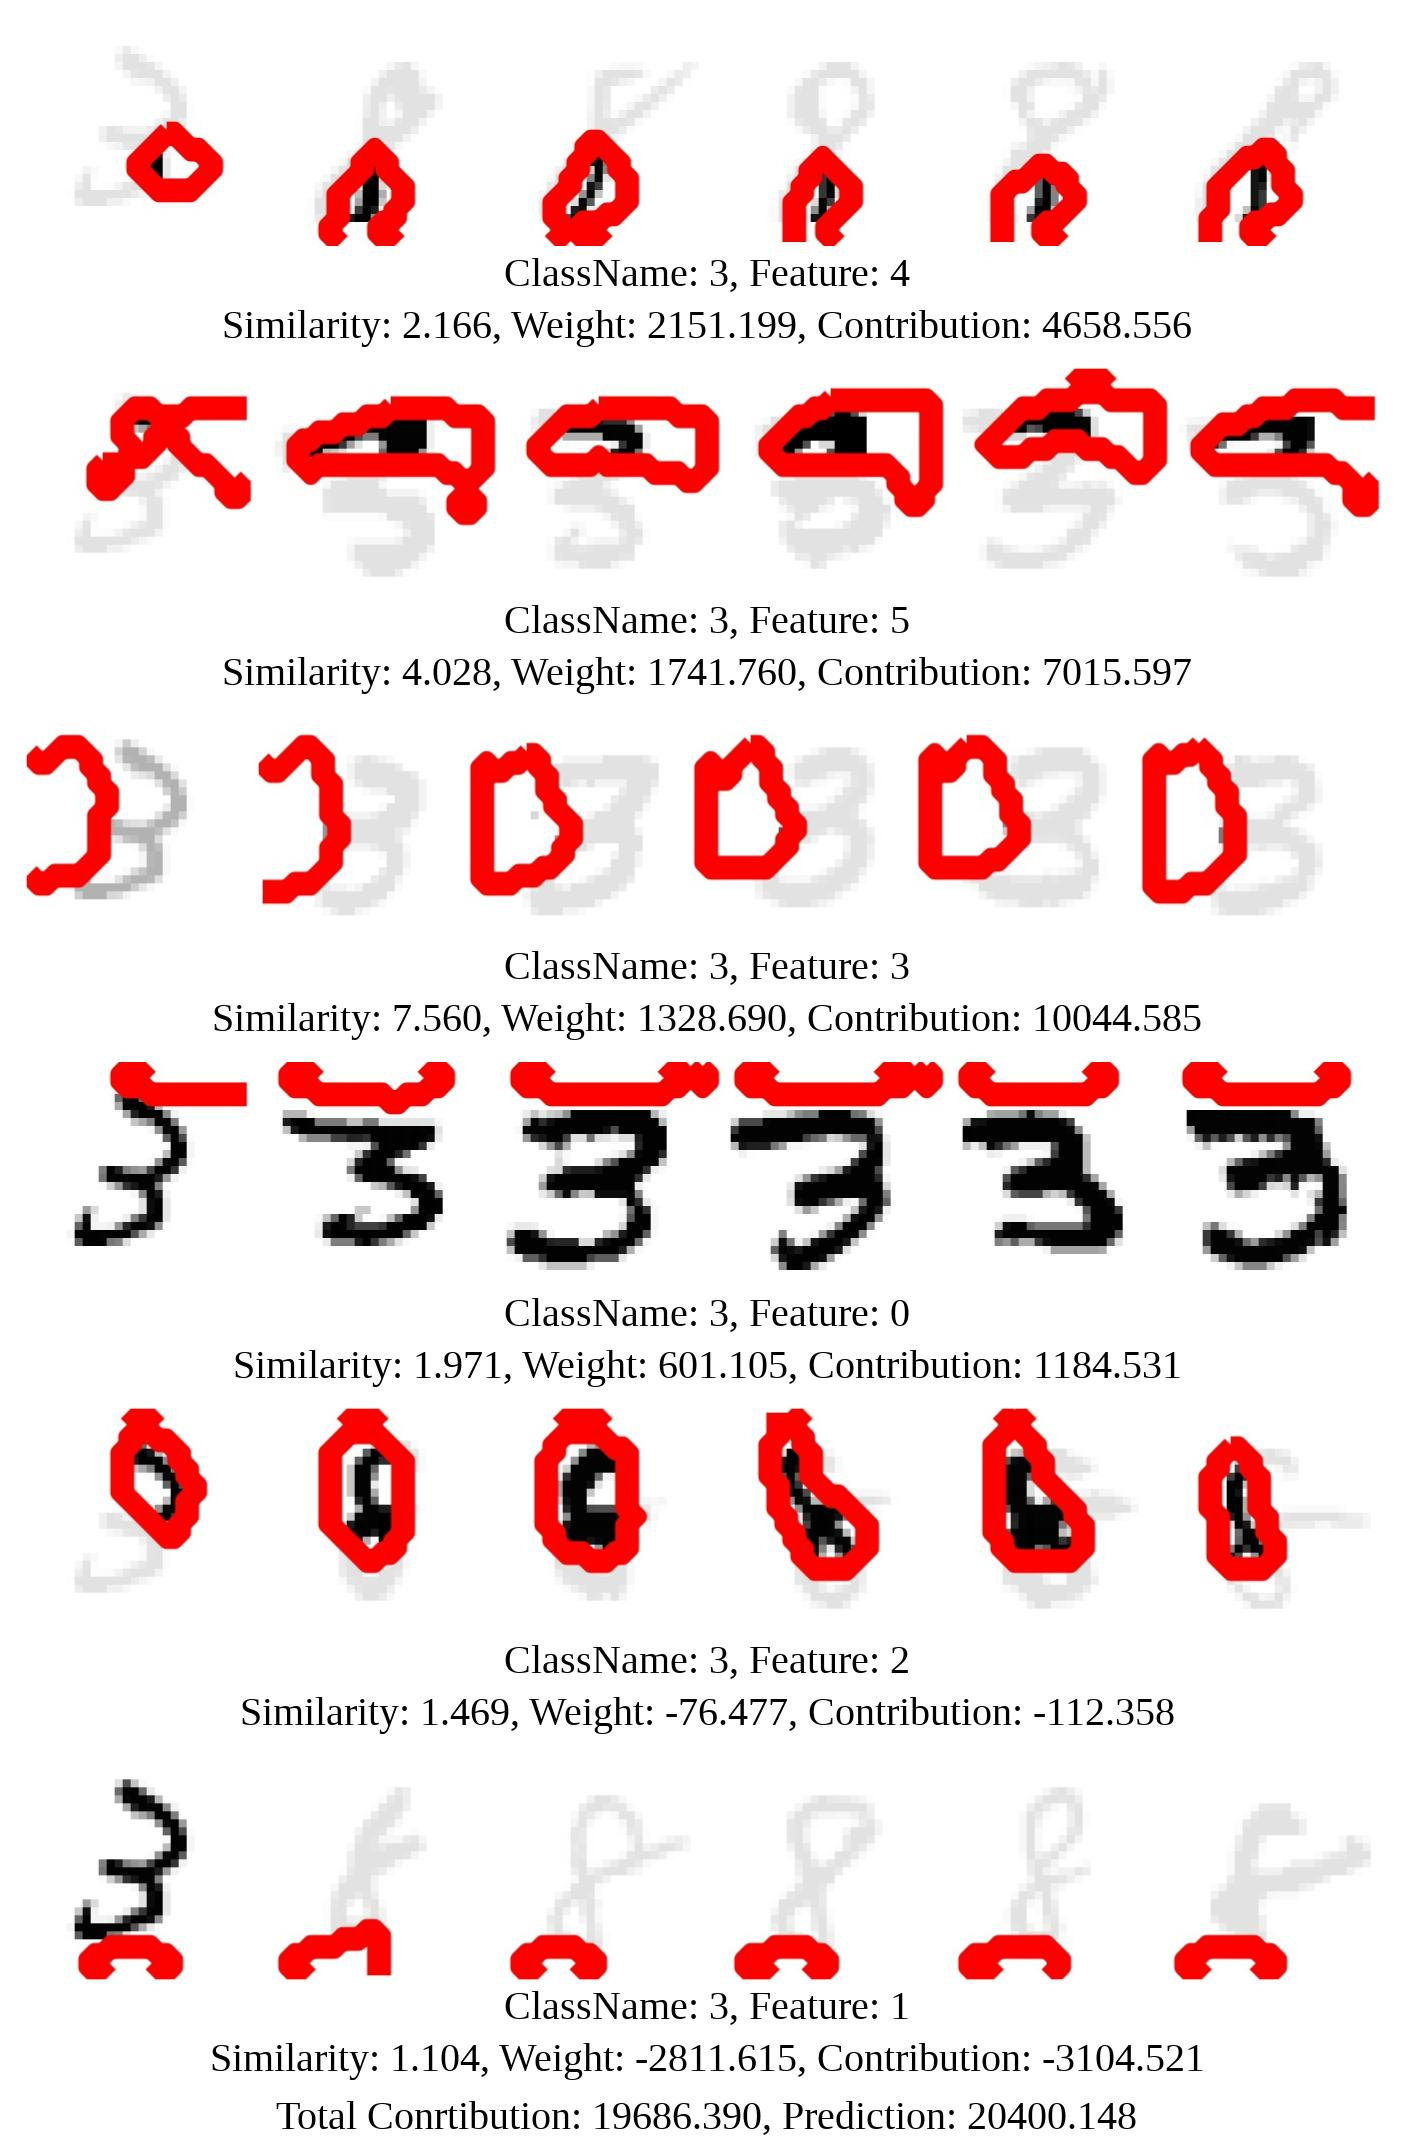

In [14]:
from IPython.display import HTML, display, Image
import os
from pathlib import Path

#@title { display-mode: "form", run: "auto" }

fpath = Path('Explainers').absolute() / title / 'explanations' / 'all'
imgfile = 'LE_3_0.jpg' #@param ['LE_3_0.jpg', 'LE_3_1.jpg']

display(Image(str(fpath/imgfile)))
